<a href="https://colab.research.google.com/github/Christheoneoneil/stat330_final/blob/model_fitting/model_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relevant Imports


In [1]:
import stan
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import seaborn as sns

# Preliminary Code Cleaning for Multinomial Logistic Regression

In [19]:
def read_data(file_name: str):
  """
  param filename: name of data file
  returns: pandas data frame
  """
  df = pd.read_csv(file_name, index_col = "Unnamed: 0")
  df.dropna(axis = 0, how="any", inplace=True)
  df = df.loc[:,~df.columns.duplicated()]
  return df

In [20]:
def prep_data(df: pd.DataFrame, key: str, unwanted_cols: list):
  """
  param df: data frame that needs to be formatted
  key: key value associated with provided dictionary
  unwanted_cols: columns that are ultimatly not needed for analysis
  returns: prept data frame for logit regression
  """
  from sklearn import preprocessing
  df_copy = df.copy()
  unnormed_cols = ["STUDWGT"]

  if key == "imputed":
    unnormed_cols = ['ACTComposite', 'SATMath', 
                     'SATVerbal', 'SATWriting'] + unnormed_cols
    df_copy.drop(columns=["Unnamed: 0.1"], inplace=True)

  normalizer = preprocessing.MinMaxScaler()
  normed_cols = normalizer.fit_transform(df[unnormed_cols])
  df_copy[unnormed_cols] = normed_cols
  df_copy.drop(columns=unwanted_cols, inplace=True)

  recode_vars = ["STRAT", "SELECTIVITY", "DOBYear"]
  for var in recode_vars:
    unencoded_list = list(df_copy[var].unique())
    encode_list = list(range(1, len(unencoded_list)+1))
    df_copy[var].replace(unencoded_list, encode_list, inplace=True)
  return(df_copy)

In [21]:
df_dict = {"imputed": read_data("data/final_frame_imputed.csv"),
           "non_imputed": read_data("data/final_frame_non_imputed.csv")}
unnecessary_cols = ["ACERECODE"]
for key, df in df_dict.items():
  df_dict[key] = prep_data(df, key, unnecessary_cols)

# Setting Up Model

In [6]:
def fit_model(model_code: str, X: np.array, Y: np.array, n: int, k: int, 
              flag_val: int):
  """
  param model_code: stan formatted code for model
  param X: nxk array of covariates 
  param Y: array of target values
  param n: number of rows 
  param k: number of covarites
  param flag_val: do predictive distrub flag value
  reutrns: stan sampler object
  """
  mod = stan.build(model_code,data={"X": X, "Y": Y, "n": n, "k": k, 
                               "do_prior_predictive": flag_val})
  samples = mod.sample()
  return samples


In [11]:
multinomial_log_stan_code = """
data {
  int<lower=0> n;                // number of units
  int<lower=0> k;                // number of covariates
  matrix[n, k] X;            // covariates for each entry, including the intercept covariate
  int<lower=1,upper=5> Y[n];     // categorical

  int do_prior_predictive;
}
parameters {
  vector[k] beta;
  vector<lower=0>[k] lambda;
  real<lower=0> tau;
  real<lower=0> sigma;            // the coefficients
}

transformed parameters {
  vector[n] mu;
  vector[n] eta;                // linear predictors
  eta = X * beta;
  mu = inv_logit(eta);
}
model {
  lambda ~ cauchy(0, 1);
  tau ~ cauchy(0, 1);
  for (i in 1:k) {
    beta[i] ~ normal(0, lambda[i] * tau);
  }
  if (do_prior_predictive != 1) {
    for (i in 1:n) {
      Y[i] ~ categorical_logit_glm(mu);
    }
  }
}
generated quantities {
  int<lower=1,upper=4> Y_tilde[n];
  for (i in 1:n) {
    Y_tilde[i] = categorical_logit_glm_rng(mu);  
  } 
}
"""

In [ ]:
target_col = "choice"
prior_pred_dict = {}
for key, df in df_dict.items():
  df = df.sample(frac=0.20)
  covars = [cov for cov in list(df.columns) if cov not in target_col]
  x = np.array(df[covars])
  n = len(x)
  x = np.concatenate((np.ones((n, 1)), x), axis=1)
  y = np.array(df[target_col], dtype="int64")
  k = x.shape[1]
  prior_pred_dict[key] = fit_model(multinomial_log_stan_code, x, y, n, k, 1)

In [66]:
# 2022-11-18 LASSO Attempt-maj
model_code = """
data {
    int<lower=1> num_classes;
    int<lower=0> n;
    int<lower=0> k;
    matrix[n, k] x;
    array[n] int<lower=1, upper=num_classes> y;

    int do_prior_predictive;
}
parameters {
    vector<lower=0>[num_classes] alpha;
    matrix[k, num_classes] beta;
    vector<lower=0>[k] lambda;
    real<lower=0> tau;
}
model {
    alpha ~ lognormal(0,1);
    lambda ~ cauchy(0,1);
    tau ~ cauchy(0,1);
    for (i in 1:k) {
        beta[i] ~ normal(0, lambda[i] * tau);
    }
    y ~ categorical_logit_glm(x, alpha, beta);
}
"""

In [69]:
df = df_dict['imputed']
target_col = "CHOICE"
df_sub = df.sample(frac=0.10)
y = df_sub[target_col].to_numpy(dtype=np.int16)
x = df_sub.drop(target_col, axis=1).to_numpy()
num_classes = len(np.unique(y))
n = x.shape[0]
k = x.shape[1]

model = stan.build(model_code, {'num_classes':num_classes, 'n':n, 'k':k, 'x':x, 'y':y, 'do_prior_predictive':0})

Building...



Building: found in cache, done.

In [72]:
fit = model.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [77]:
fit

<stan.Fit>
Parameters:
    alpha: (4,)
    beta: (79, 4)
    lambda: (79,)
    tau: ()
Draws: 4000

In [90]:
# Check divergences
np.sum(fit['divergent__'])

252.0

In [86]:
list(fit.to_frame().columns)

['lp__',
 'accept_stat__',
 'stepsize__',
 'treedepth__',
 'n_leapfrog__',
 'divergent__',
 'energy__',
 'alpha.1',
 'alpha.2',
 'alpha.3',
 'alpha.4',
 'beta.1.1',
 'beta.2.1',
 'beta.3.1',
 'beta.4.1',
 'beta.5.1',
 'beta.6.1',
 'beta.7.1',
 'beta.8.1',
 'beta.9.1',
 'beta.10.1',
 'beta.11.1',
 'beta.12.1',
 'beta.13.1',
 'beta.14.1',
 'beta.15.1',
 'beta.16.1',
 'beta.17.1',
 'beta.18.1',
 'beta.19.1',
 'beta.20.1',
 'beta.21.1',
 'beta.22.1',
 'beta.23.1',
 'beta.24.1',
 'beta.25.1',
 'beta.26.1',
 'beta.27.1',
 'beta.28.1',
 'beta.29.1',
 'beta.30.1',
 'beta.31.1',
 'beta.32.1',
 'beta.33.1',
 'beta.34.1',
 'beta.35.1',
 'beta.36.1',
 'beta.37.1',
 'beta.38.1',
 'beta.39.1',
 'beta.40.1',
 'beta.41.1',
 'beta.42.1',
 'beta.43.1',
 'beta.44.1',
 'beta.45.1',
 'beta.46.1',
 'beta.47.1',
 'beta.48.1',
 'beta.49.1',
 'beta.50.1',
 'beta.51.1',
 'beta.52.1',
 'beta.53.1',
 'beta.54.1',
 'beta.55.1',
 'beta.56.1',
 'beta.57.1',
 'beta.58.1',
 'beta.59.1',
 'beta.60.1',
 'beta.61.1',
 'b

In [91]:
fit.to_frame().to_csv("data/lasso_fit.csv", index=False)

In [78]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.665,0.547,0.048,1.635,0.011,0.008,2847.0,2708.0,1.00
alpha[1],9.770,0.931,8.077,11.502,0.023,0.016,1688.0,2202.0,1.00
alpha[2],8.718,1.040,6.929,10.763,0.024,0.017,1827.0,2373.0,1.00
alpha[3],7.656,1.197,5.576,9.984,0.031,0.022,1431.0,2100.0,1.01
"beta[0, 0]",0.007,0.016,-0.021,0.039,0.000,0.000,2268.0,1569.0,1.00
...,...,...,...,...,...,...,...,...,...
lambda[75],3.120,5.473,0.006,12.211,0.397,0.281,190.0,289.0,1.02
lambda[76],16.214,14.145,0.036,37.112,0.884,0.625,160.0,192.0,1.04
lambda[77],3.407,5.782,0.013,13.492,0.378,0.268,148.0,349.0,1.03
lambda[78],3.933,7.217,0.015,16.045,0.570,0.404,152.0,268.0,1.02


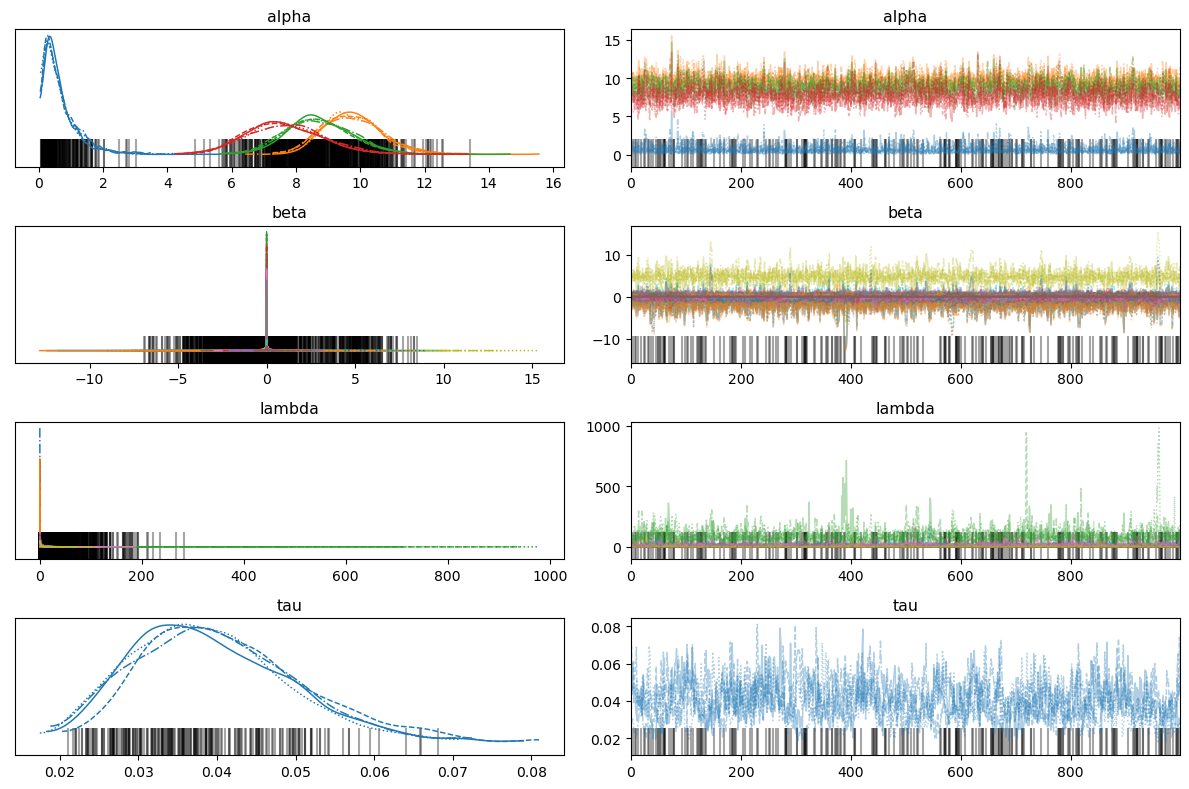

In [94]:
az.plot_trace(fit, divergences="bottom")
plt.tight_layout()
plt.show();

In [98]:
import pickle
with open("data/lasso_model.pickle", "wb") as f:
    pickle.dump(fit, f)

In [99]:
# with open("data/lasso_model.pickle", "rb") as f:
#     foo = pickle.load(f)